In [ ]:
!git clone https://github.com/ch2343/scCRAFT.git

In [ ]:
%cd scCRAFT
!pip install .

In [ ]:
!pip install harmonypy

In [1]:
import scanpy as sc
import numpy as np
import scCRAFT
from scCRAFT.model import *
import harmonypy as hm
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import scib
import louvain
import scanpy as sc
import scvi
import seaborn as sns
import torch
import scanorama

/Users/sheena/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore")

/Users/sheena/Library/Python/3.9/lib/python/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/Users/sheena/Library/Python/3.9/lib/python/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


In [14]:
import anndata
adata = anndata.read_h5ad("../macaque_raw.h5ad")
adata

AnnData object with n_obs × n_vars = 30302 × 36162
    obs: 'batch', 'sample', 'macaque_id', 'nGene', 'nTranscripts', 'cluster', 'region', 'class', 'cell_type', 'BATCH'
    var: 'gene_name'

In [15]:
adata.obs['batch'] = adata.obs['sample'].values

In [16]:
# preprocessing
adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

In [17]:
embeddings_dict = {}

In [21]:
adata

AnnData object with n_obs × n_vars = 30302 × 2000
    obs: 'batch', 'sample', 'macaque_id', 'nGene', 'nTranscripts', 'cluster', 'region', 'class', 'cell_type', 'BATCH', 'n_genes', 'n_counts'
    var: 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    obsm: 'X_scVI', 'X_harmony', 'X_scCRAFT', 'X_seurat'
    layers: 'counts'

# Scanorama

In [7]:
import anndata as ad

def split_batches(adata, batch_key, return_categories=False):
    """
    Split an AnnData object into a list of AnnData objects by batch.
    
    Parameters:
    - adata (AnnData): The AnnData object to split.
    - batch_key (str): The key in `adata.obs` used to identify batches.
    - return_categories (bool): Whether to return the unique categories (batch labels).

    Returns:
    - list: A list of AnnData objects, one for each batch.
    - list (optional): A list of unique batch categories, if `return_categories` is True.
    """
    if batch_key not in adata.obs:
        raise ValueError(f"Batch key '{batch_key}' not found in adata.obs.")
    
    categories = adata.obs[batch_key].unique().tolist()
    split_data = [adata[adata.obs[batch_key] == batch].copy() for batch in categories]
    
    if return_categories:
        return split_data, categories
    return split_data

In [22]:
print(type(adata.X))  # Check the type of the main matrix in AnnData

<class 'scipy.sparse._csc.csc_matrix'>


In [23]:
from scipy.sparse import csc_matrix

if isinstance(adata.X, csc_matrix):
    adata.X = adata.X.tocsr()

In [24]:
#Scanorama
# Save original order of cells
original_order = adata.obs_names.copy()

# Your existing Scanorama correction process
split, categories = split_batches(adata.copy(), 'batch', return_categories=True)
corrected = scanorama.correct_scanpy(split, return_dimred=True)
corrected = anndata.AnnData.concatenate(
    *corrected, batch_key='batch', batch_categories=categories, index_unique=None
)

# Reorder corrected data to match original order
corrected = corrected[original_order]

# Replace adata with corrected data
adatas = corrected.copy()

Found 2000 genes among all datasets
[[0.00000000e+00 8.68020305e-01 6.37254902e-01 7.70727580e-01
  7.38793103e-01 6.29161883e-01 6.03648425e-01 4.96368039e-01
  3.02571861e-03 4.84848485e-03 0.00000000e+00 1.41643059e-03
  1.77304965e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.60000000e-03 2.53807107e-03 2.36406619e-03 0.00000000e+00
  0.00000000e+00 1.21802680e-03 0.00000000e+00 1.69204738e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.56862745e-01 7.93767186e-01
  7.26724138e-01 6.60160735e-01 5.55453712e-01 5.69007264e-01
  4.53857791e-03 4.84848485e-03 2.22222222e-03 0.00000000e+00
  0.00000000e+00 1.09649123e-03 0.00000000e+00 3.08324769e-03
  3.20000000e-03 1.83318057e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 5.18134715e-03 4.96453901e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.16590284e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+0

In [25]:
adata.obsm['X_scanorama'] = adatas.obsm['X_scanorama']

embeddings_dict['X_scanorama'] = adata.obsm["X_scanorama"]

In [26]:
embeddings_dict.keys()

dict_keys(['X_scVI', 'X_harmony', 'X_scCRAFT', 'X_seurat', 'X_scanorama'])

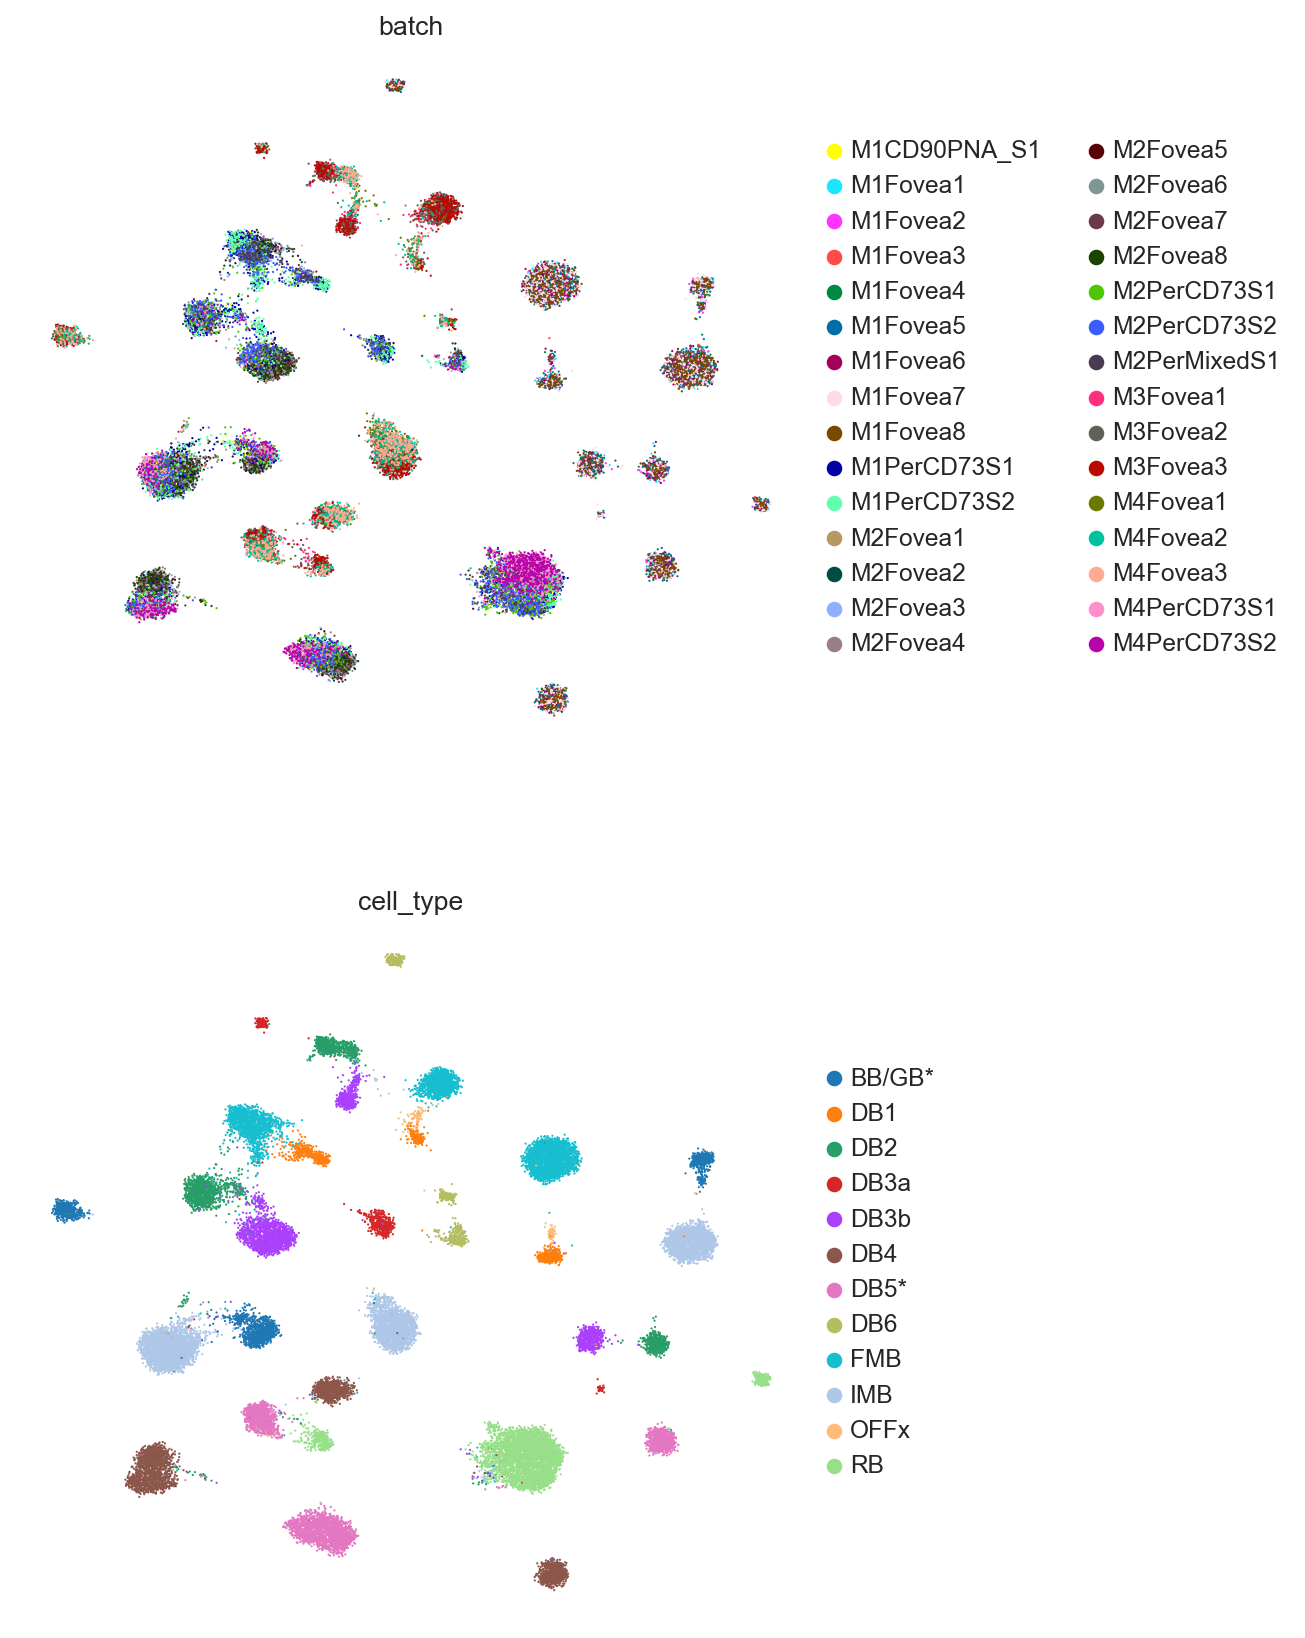

In [28]:
# Umap Plotting
sc.pp.neighbors(adata, n_pcs=30, use_rep="X_scanorama")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

# scCRAFT

In [6]:
# scCRAFT
multi_resolution_cluster(adata, resolution1 = 1, method = 'Leiden')
VAE = train_integration_model(adata, batch_key = 'batch', z_dim=256, d_coef = 0.2)
obtain_embeddings(adata, VAE)
sc.pp.neighbors(adata, use_rep="X_scCRAFT")
sc.tl.umap(adata, min_dist=0.5)

150


Overall Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Training completed in 1104.36 seconds


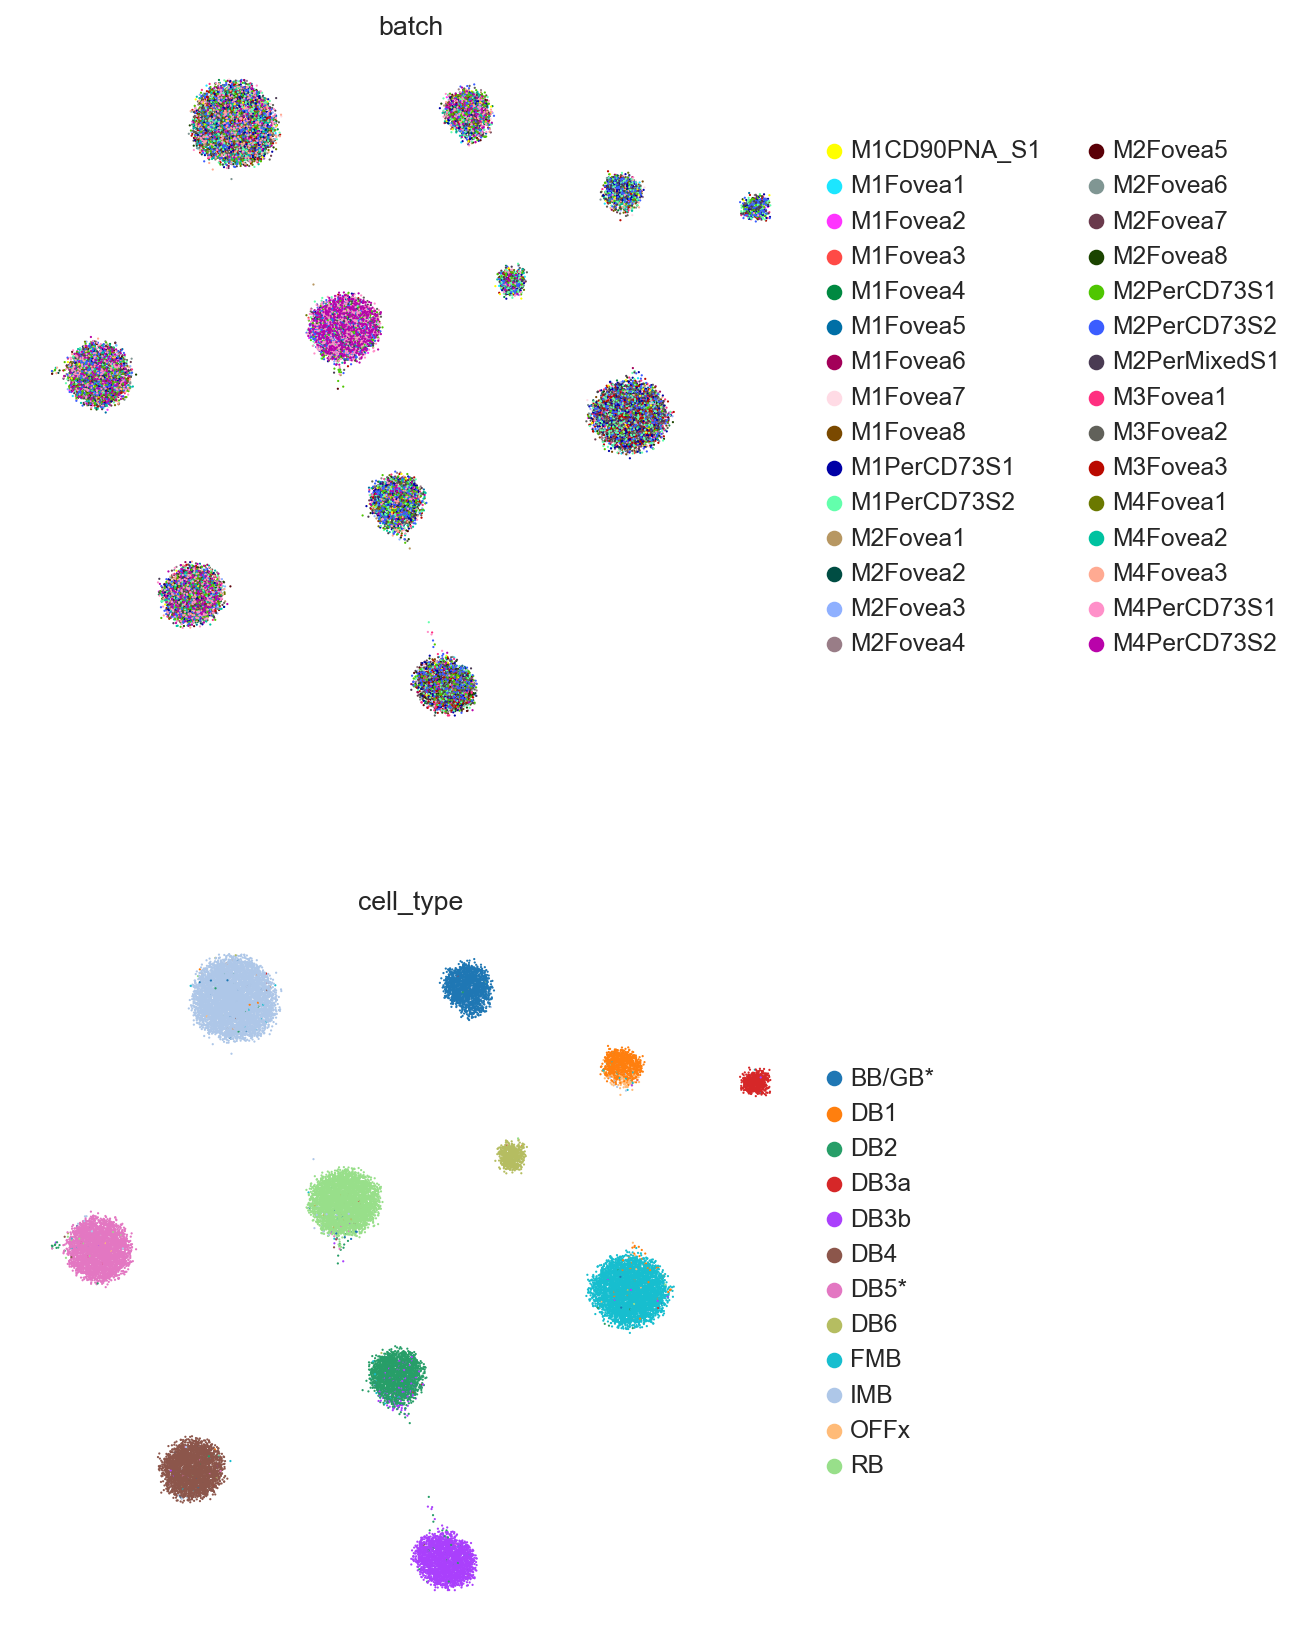

In [7]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [8]:
# Save embeddings
adata.obsm["X_scCRAFT"] = adata.obsm["X_scCRAFT"]

# Collect embeddings
embeddings_dict = {"X_scCRAFT": adata.obsm["X_scCRAFT"]}

# scVI

In [9]:
# scVI
adata = adata.copy()
adata.layers['counts'] = adata.X
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 264/264: 100%|█| 264/264 [13:33<00:00,  2.96s/it, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=264` reached.


Epoch 264/264: 100%|█| 264/264 [13:33<00:00,  3.08s/it, v_num=1, train_loss_step


In [10]:
# Assuming 'vae' is your trained model
model_path = "./model_scVI"
vae.save(model_path, overwrite=True)

In [11]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

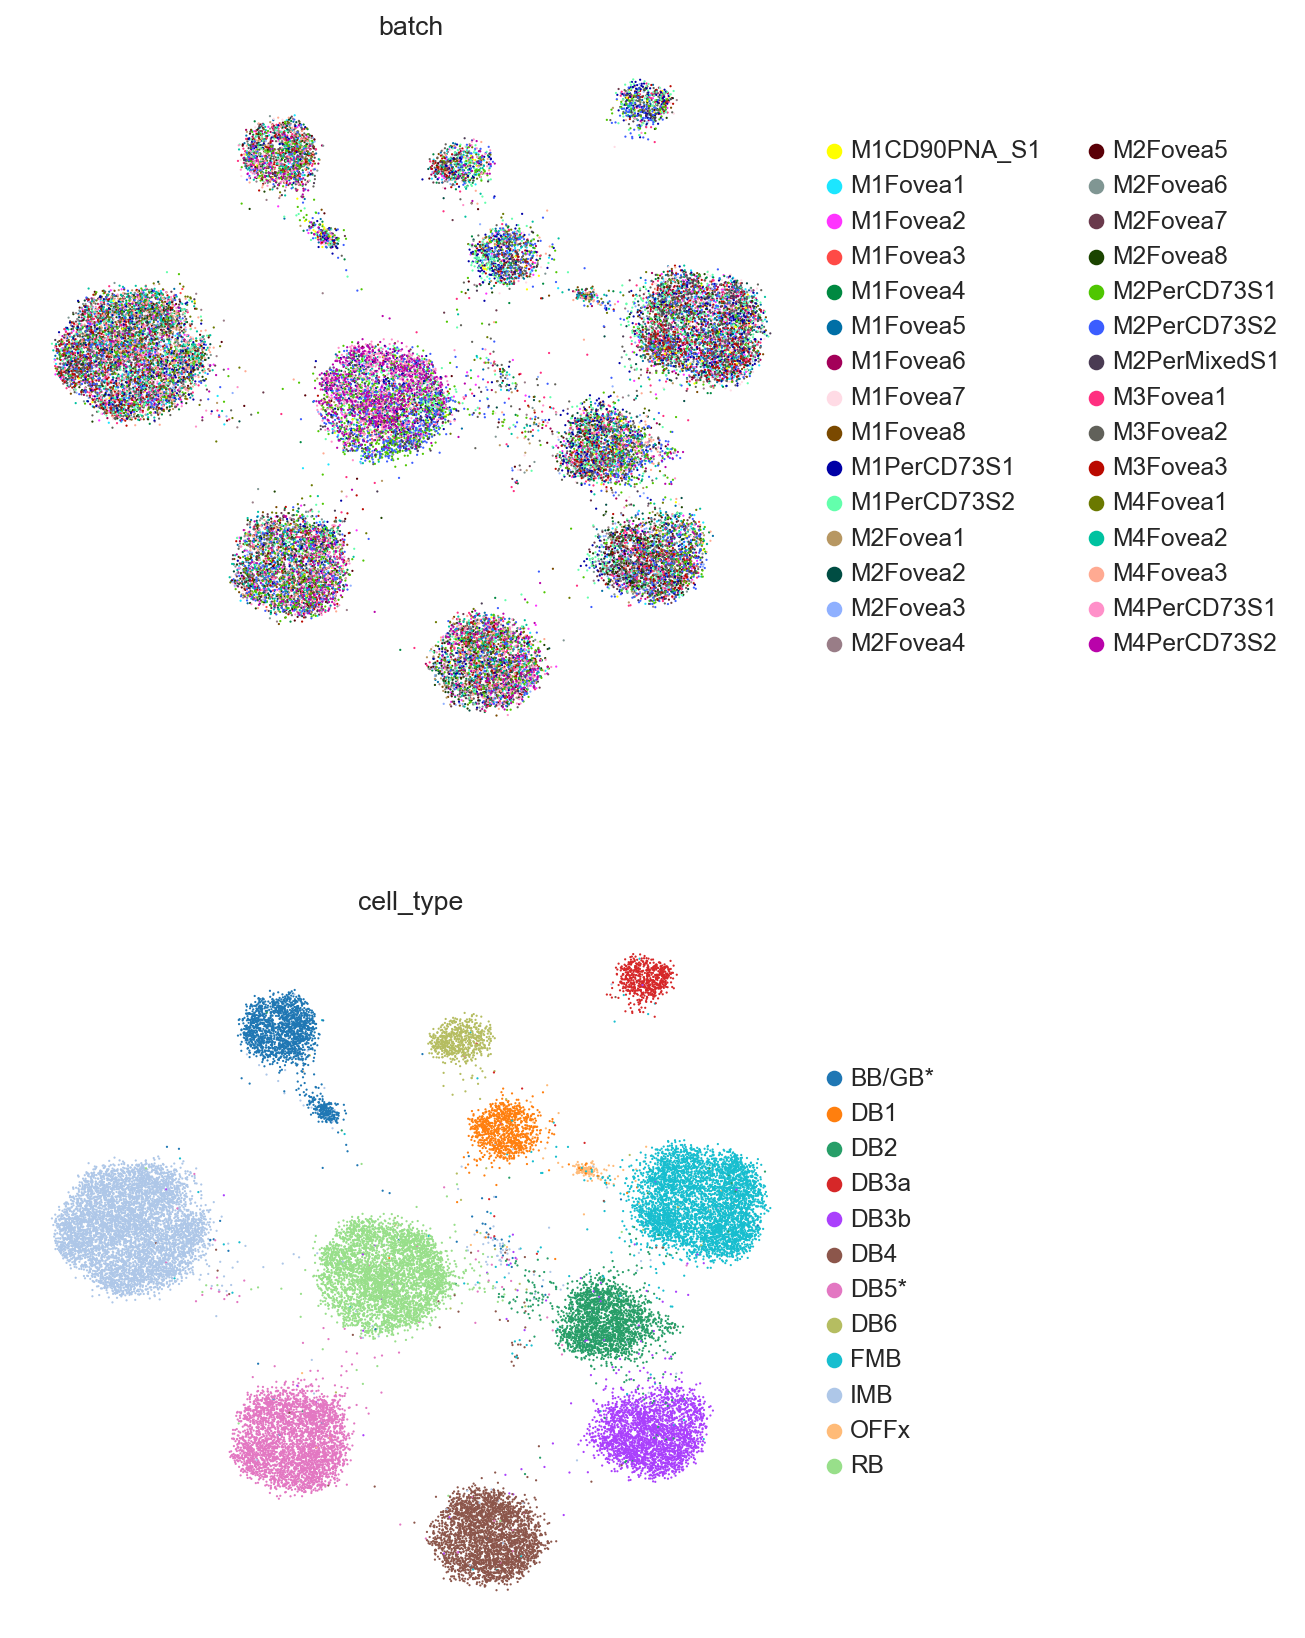

In [12]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

# Harmony

In [13]:
# Harmony
sc.tl.pca(adata, n_comps=50)
data_mat = adata.obsm['X_pca']
meta_data = adata.obs

# Specify the variables to use (as in your original code)
vars_use = ['batch']

# Run Harmony
start_time = time.time()
ho = hm.run_harmony(data_mat, meta_data, vars_use)
end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Convert the adjusted PCs to a DataFrame
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

# If you want to store the adjusted PCs back into the AnnData object
adata.obsm['X_harmony'] = res.values.T
sc.pp.neighbors(adata, use_rep="X_harmony")
sc.tl.umap(adata, min_dist=0.5)

2024-09-09 10:56:23,746 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-09-09 10:56:29,773 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-09-09 10:56:29,960 - harmonypy - INFO - Iteration 1 of 10
2024-09-09 10:56:47,306 - harmonypy - INFO - Iteration 2 of 10
2024-09-09 10:57:03,106 - harmonypy - INFO - Iteration 3 of 10
2024-09-09 10:57:16,092 - harmonypy - INFO - Converged after 3 iterations


Training completed in 52.36 seconds


In [14]:
# Save embeddings
adata.obsm["X_harmony"] = adata.obsm["X_harmony"]

# Collect embeddings
embeddings_dict["X_harmony"] = adata.obsm["X_harmony"]

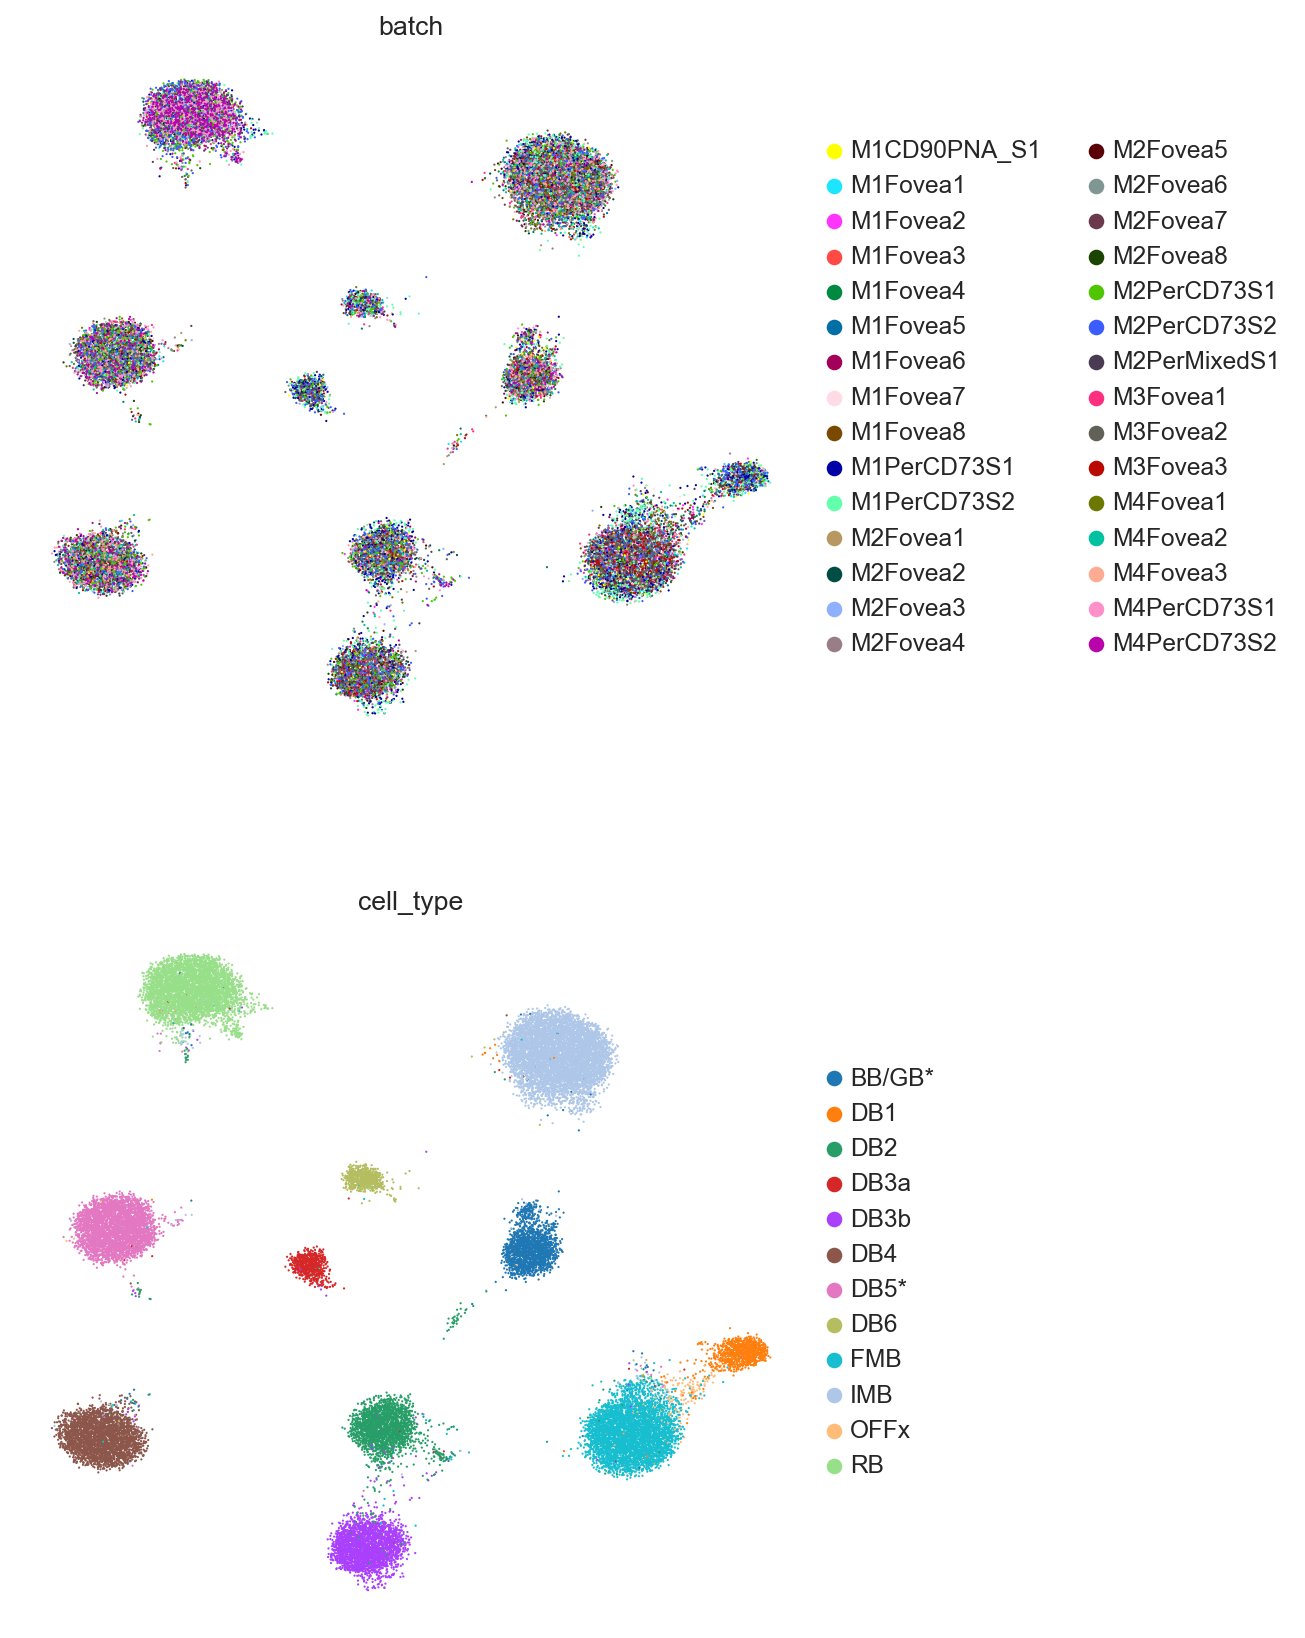

In [15]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

# Seurat

In [16]:
pca_embeddings = pd.read_csv('../R_macaque/embeddings/macaque_seurat_embeddings.csv', index_col=0)
adata.obsm['X_seurat'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_seurat")
sc.tl.umap(adata, min_dist=0.5)

In [17]:
# Collect embeddings
embeddings_dict["X_seurat"] = adata.obsm["X_seurat"]

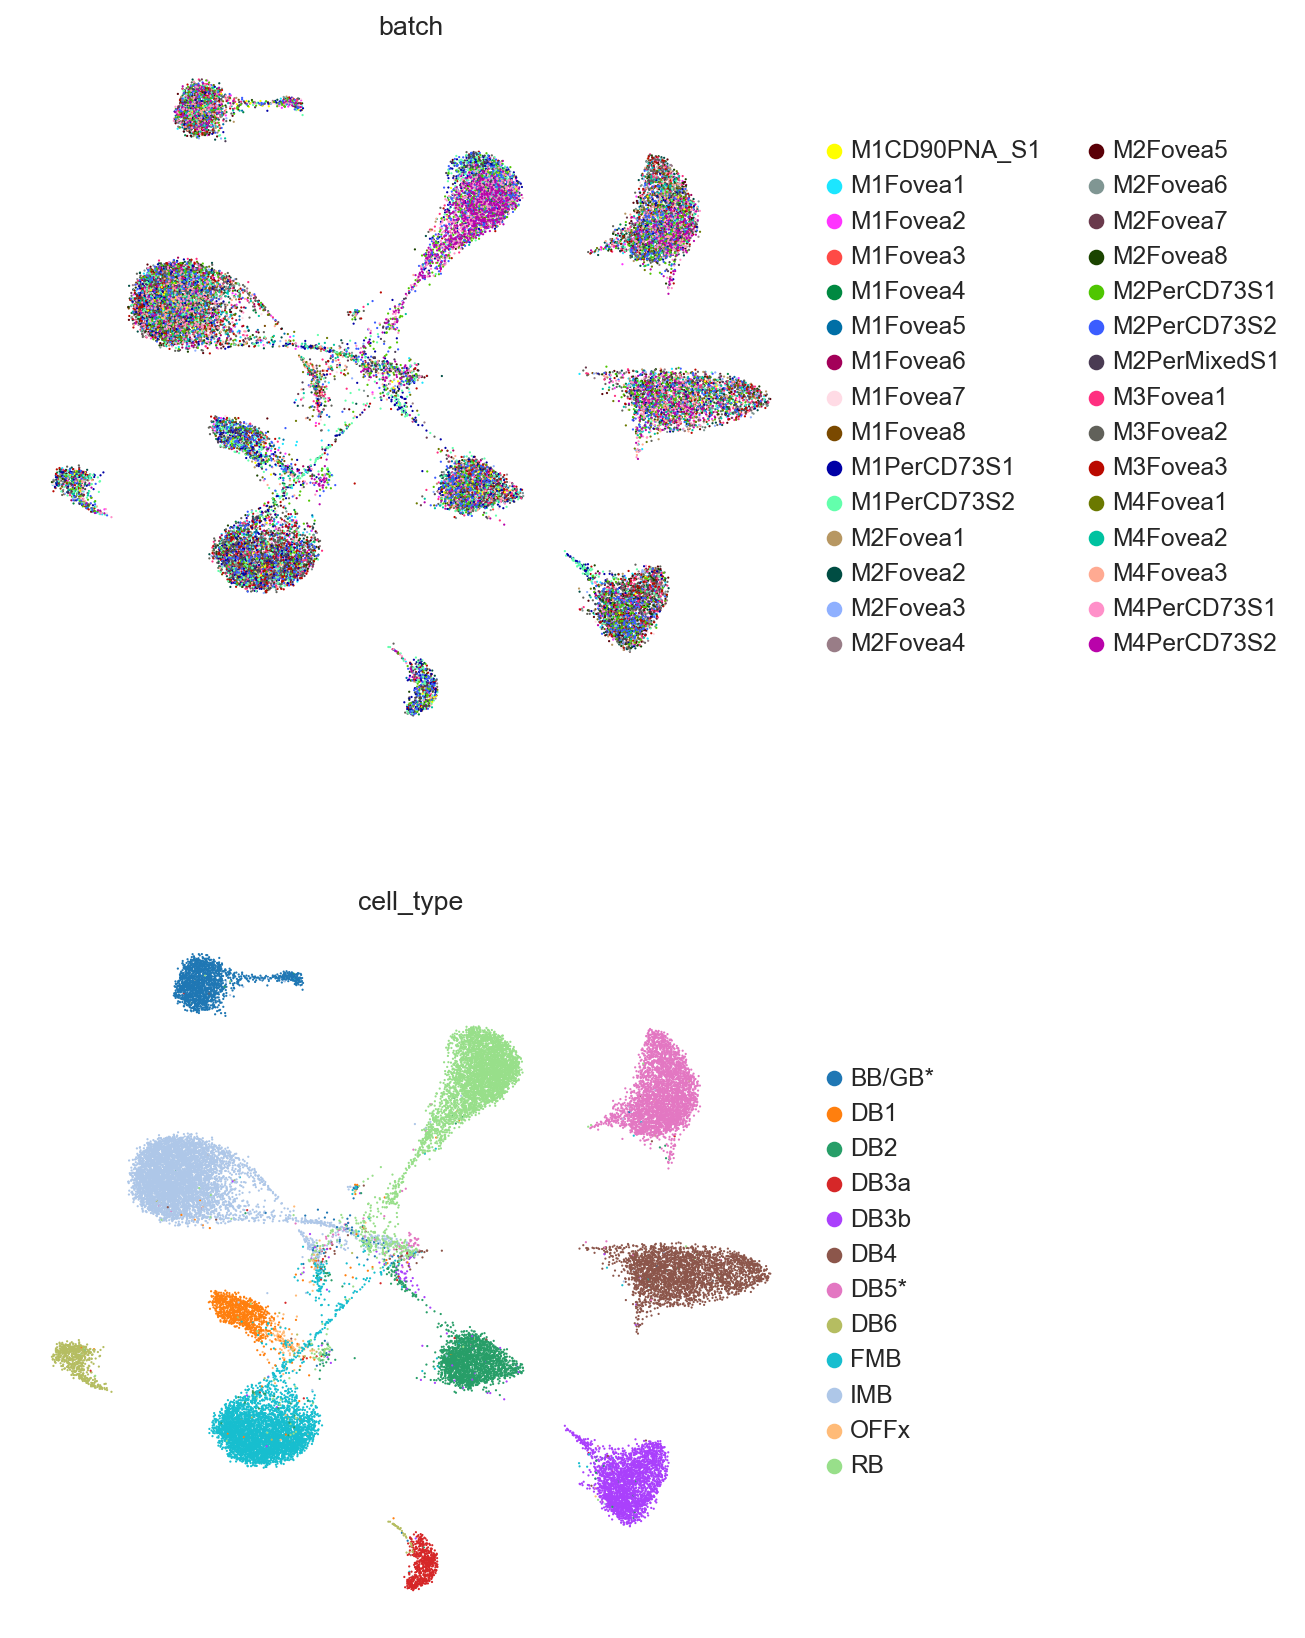

In [18]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [29]:
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/full_annotated_unsupervised_macaque.csv")


# Metric Evaluation

## read the embeddings

In [18]:
# Step 1: Read the CSV file into a DataFrame
combined_embeddings = pd.read_csv("../embeddings/full_annotated_unsupervised_macaque.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scVI", "X_harmony", "X_scCRAFT", "X_seurat"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [14]:
sc.pp.neighbors(adata, use_rep="X_scVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scVI')

resolution: 0.1, nmi: 0.8191687623613476
resolution: 0.2, nmi: 0.8752033374808829
resolution: 0.3, nmi: 0.9162417160864583
resolution: 0.4, nmi: 0.9165855555005674
resolution: 0.5, nmi: 0.9366110262195625
resolution: 0.6, nmi: 0.9365941561569816
resolution: 0.7, nmi: 0.9363666836760733
resolution: 0.8, nmi: 0.9315997561122695
resolution: 0.9, nmi: 0.9195293487595959
resolution: 1.0, nmi: 0.9194677795713039
resolution: 1.1, nmi: 0.919746175350378
resolution: 1.2, nmi: 0.8793983576878831
resolution: 1.3, nmi: 0.8789952896649205
resolution: 1.4, nmi: 0.8790282583448019
resolution: 1.5, nmi: 0.880666235005783
resolution: 1.6, nmi: 0.8682938922585768
resolution: 1.7, nmi: 0.8677356853817539
resolution: 1.8, nmi: 0.8678281883041247
resolution: 1.9, nmi: 0.8676949472773421
resolution: 2.0, nmi: 0.8579092521677121
optimised clustering against cell_type
optimal cluster resolution: 0.5
optimal score: 0.9366110262195625
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on 

In [15]:
sc.pp.neighbors(adata, use_rep="X_harmony")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_harmony')

resolution: 0.1, nmi: 0.9022668867714307
resolution: 0.2, nmi: 0.9199347555921404
resolution: 0.3, nmi: 0.9307483214570366
resolution: 0.4, nmi: 0.9196103000063683
resolution: 0.5, nmi: 0.9192357788345613
resolution: 0.6, nmi: 0.9194385823058009
resolution: 0.7, nmi: 0.9194045474379091
resolution: 0.8, nmi: 0.8977745840763673
resolution: 0.9, nmi: 0.8723820850002534
resolution: 1.0, nmi: 0.8744171130912585
resolution: 1.1, nmi: 0.8565707124316283
resolution: 1.2, nmi: 0.8562232051348648
resolution: 1.3, nmi: 0.8561964892883255
resolution: 1.4, nmi: 0.8559751086190024
resolution: 1.5, nmi: 0.8537419675477927
resolution: 1.6, nmi: 0.8537629842905119
resolution: 1.7, nmi: 0.8532089632371885
resolution: 1.8, nmi: 0.8534208080932252
resolution: 1.9, nmi: 0.8542391594909844
resolution: 2.0, nmi: 0.8540414813308465
optimised clustering against cell_type
optimal cluster resolution: 0.3
optimal score: 0.9307483214570366
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors o

In [16]:
sc.pp.neighbors(adata, use_rep="X_scCRAFT")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scCRAFT')

resolution: 0.1, nmi: 0.8537705499027669
resolution: 0.2, nmi: 0.8536196872772074
resolution: 0.3, nmi: 0.8608105259431799
resolution: 0.4, nmi: 0.8540648895626409
resolution: 0.5, nmi: 0.8540648895626409
resolution: 0.6, nmi: 0.8540648895626409
resolution: 0.7, nmi: 0.8579859953553249
resolution: 0.8, nmi: 0.8617906507479905
resolution: 0.9, nmi: 0.8622788101870528
resolution: 1.0, nmi: 0.8622692448017623
resolution: 1.1, nmi: 0.8621412885031353
resolution: 1.2, nmi: 0.8597802514710398
resolution: 1.3, nmi: 0.8597802514710398
resolution: 1.4, nmi: 0.8592671395227395
resolution: 1.5, nmi: 0.860035650013798
resolution: 1.6, nmi: 0.8599135097657384
resolution: 1.7, nmi: 0.8594013108729684
resolution: 1.8, nmi: 0.8595714773999753
resolution: 1.9, nmi: 0.8594992265388042
resolution: 2.0, nmi: 0.860114786482927
optimised clustering against cell_type
optimal cluster resolution: 0.9
optimal score: 0.8622788101870528
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on 

In [17]:
sc.pp.neighbors(adata, use_rep="X_seurat")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df4_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_seurat')

resolution: 0.1, nmi: 0.8826873050999023
resolution: 0.2, nmi: 0.881919921191126
resolution: 0.3, nmi: 0.8758259443045961
resolution: 0.4, nmi: 0.855828358687419
resolution: 0.5, nmi: 0.8544249830067656
resolution: 0.6, nmi: 0.8401289107724472
resolution: 0.7, nmi: 0.827407165750886
resolution: 0.8, nmi: 0.8260644027072638
resolution: 0.9, nmi: 0.8237391441388776
resolution: 1.0, nmi: 0.8216059611913366
resolution: 1.1, nmi: 0.8169251782332908
resolution: 1.2, nmi: 0.8187579866490367
resolution: 1.3, nmi: 0.8185222805594077
resolution: 1.4, nmi: 0.8184371784442569
resolution: 1.5, nmi: 0.8057303123148453
resolution: 1.6, nmi: 0.7982473859464915
resolution: 1.7, nmi: 0.7969624345860677
resolution: 1.8, nmi: 0.7974147186217028
resolution: 1.9, nmi: 0.7898190194320863
resolution: 2.0, nmi: 0.7900567138500149
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.8826873050999023
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on r

In [18]:
# Adding new columns to each dataframe
df1_1['scVI'] = df1_1.iloc[:, 0]
df2_1['Harmony'] = df2_1.iloc[:, 0]
df3_1['scCRAFT'] = df3_1.iloc[:, 0]
df4_1['Seurat'] = df4_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scVI']]
df2_1 = df2_1[['Harmony']]
df3_1 = df3_1[['scCRAFT']]
df4_1 = df4_1[['Seurat']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1, df4_1], axis=1)

merged_df.to_csv("../metrics/macaque_metrics_unsupervised.csv", index=True)

In [19]:
merged_df

,scVI,Harmony,scCRAFT,Seurat
NMI_cluster/label,0.938266,0.938042,0.861724,0.890781
ARI_cluster/label,0.956160,0.955946,0.776159,0.866766
ASW_label,0.540412,0.572737,0.661866,0.598326
ASW_label/batch,0.968073,0.944976,0.884441,0.897120
PCR_batch,NaN,NaN,NaN,NaN
cell_cycle_conservation,NaN,NaN,NaN,NaN
isolated_label_F1,0.964389,0.908917,0.841070,0.885180
isolated_label_silhouette,0.548688,0.568593,0.652081,0.594978
graph_conn,0.988857,0.979920,0.985004,0.990849
kBET,NaN,NaN,NaN,NaN
